# Reliability analysis: FORM

This example file demonstrates how to use the FORM class of UQpy to compute a probability of failure. The computational model consists in an Abaqus model of a beam subjected to mechanical and fire loads - see **section 5.1** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification".  

The files necessary to run this example are:
1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus. 

## The model

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.RunModel import *
from UQpy.Reliability import FORM
from UQpy.Distributions import Normal, Uniform
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np

calling_directory = os.getcwd()
t = time.time()

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

#### Create the model object

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py',
                            var_names=var_names, ntasks=1, model_dir='SFE_Example', verbose=False)
print('Example: Created the model object.')

Example: Created the model object.


### Instantiate a UQpy TaylorSeries object 

The fire load density is assumed to be uniformly distributed between $50 MJ/m^2$ and $450 MJ/m^2$. The yield strength is assumed to be normally distributed, with the parameters being: $\mu = 250MPa$ and coefficient of variation of $c.o.v =7\%$.

In [4]:
dist1 = Uniform(loc=50, scale=400)
dist2 = Normal(loc=250e6, scale=17.5e6)

Q = FORM(dist_object=[dist1,dist2], runmodel_object=abaqus_sfe_model, n_iter=100)
Q.run(seed_u=np.array([1.0, 1.0]))

### Print the results

In [5]:
print('Design point in standard normal space: %s' % Q.DesignPoint_U)
print('Design point in original space: %s' % Q.DesignPoint_X)
print('Hasofer-Lind reliability index: %s' % Q.beta_form)
print('FORM probability of failure: %s' % Q.Pf_form)

Design point in standard normal space: [array([ 1.62174015, -0.57237888])]
Design point in original space: [array([4.29028201e+02, 2.39983370e+08])]
Hasofer-Lind reliability index: [1.7180916517172802]
FORM probability of failure: [0.04288994966058033]


### Save the results

In [6]:
results = {'outputs': [Q.DesignPoint_U, Q.DesignPoint_X, Q.beta_form, Q.Pf_form, Q.form_iterations,
                       Q.g_record, Q.dg_u_record, Q.x_record, Q.u_record, Q.alpha_record]}

# Pickle the results dictionary in the current directory. The basename and extension of the desired pickle file:
res_basename = 'FORM_results'
res_extension = '.pkl'

# Create a new results file with a larger index than any existing results files with the same name in the current
# directory.
res_file_list = glob.glob(res_basename + '_???' + res_extension)
if len(res_file_list) == 0:
    res_file_name = res_basename + '_000' + res_extension
else:
    max_number = max(res_file_list).split('.')[0].split('_')[-1]
    res_file_name = res_basename + '_%03d' % (int(max_number) + 1) + res_extension

res_file_name = os.path.join(calling_directory, res_file_name)
# Save the results to this new file.
with open(res_file_name, 'wb') as f:
    pickle.dump(results, f)
print('Saved the results to ' + res_file_name)


print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

Saved the results to C:\Users\mohitsinghchauhan\Desktop\UQpyPaper\Abaqus_FORM_example\FORM_results_002.pkl
Example: Done!
Time elapsed: 9.93 minutes


In [7]:
# Supporting function
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

# Supporting function
def multivariate(xi, yi, N):
    Z0 = np.zeros(N)
    Z1 = np.zeros(N)
    Z = np.zeros(shape=(N, N))
    
    x = np.zeros(N)
    y = np.zeros(N)
    for j1 in range(N):
        x[j1] = dist1.pdf(xi[j1].reshape(1, -1))
        y[j1] = dist2.pdf(yi[j1].reshape(1, -1))
        
    for i1 in range(N):
            Z0[i1] = x[i1]
            Z1[i1] = y[i1]  
    
    for j1 in range(N):
        for j2 in range(N):
            Z[j1, j2] = Z0[j1] * Z1[j2]
        
    return Z0, Z1, Z

In [8]:
N = 100
i_coords = np.linspace(50, 450, N)
j_coords = np.linspace(200e6, 300e6, N)
XX, YY = np.meshgrid(i_coords, j_coords)
Z0, Z1, Z = multivariate(i_coords, j_coords,N)

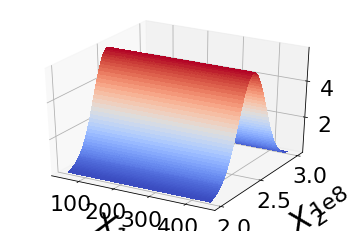

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.ticker as mticker

# Figure 13a
fig = plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 22})
ax = fig.add_subplot(111, projection='3d')
XX, YY = np.meshgrid(i_coords, j_coords)
ax.plot_surface(XX, YY, Z.T, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel(r'$X_1$', FontSize=32)
ax.set_ylabel(r'$X_2$', FontSize=32)
ax.set_zlabel(r'$pdf$', FontSize=32)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=5)
ax.xaxis.labelpad = 10 
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 15
# plt.savefig('Joint_density.pdf')
plt.show()

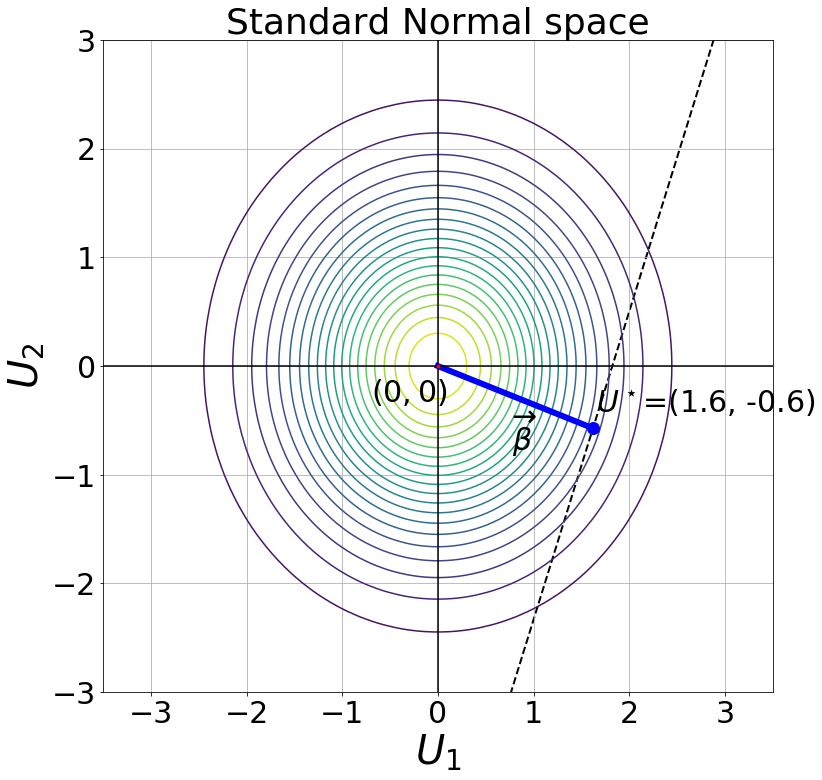

In [10]:
N = 100

XU = np.linspace(-3, 3, N)
YU = np.linspace(-3, 3, N)
XU, YU = np.meshgrid(XU, YU)

# Mean vector and covariance matrix in the ostandard normal space
mu_U = np.array([0., 0.])
Sigma_U = np.array([[ 1. , 0.0], [0.0,  1]])

# Pack X and Y into a single 3-dimensional array for the standard normal space
posU = np.empty(XU.shape + (2,))
posU[:, :, 0] = XU
posU[:, :, 1] = YU
ZU = multivariate_gaussian(posU, mu_U, Sigma_U)
# Figure 13c
MPP_U = [Q.DesignPoint_U[0][0], Q.DesignPoint_U[0][1]]
plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 30})      
plt.plot([0, MPP_U[0]],[0, MPP_U[1]], 'b', Linewidth=6)   
plt.plot(MPP_U[0], MPP_U[1],'bo',markersize=12)
plt.contour(XU, YU, ZU, levels=20)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.plot(0,0,'r.')

u_hat = np.array([MPP_U[0], MPP_U[1]])
v_hat = np.array([-MPP_U[1], MPP_U[0]])
vr = 5 * v_hat/(np.linalg.norm(v_hat))
a_hat = u_hat + vr
b_hat = u_hat - vr
plt.plot([a_hat[0],  b_hat[0]],[a_hat[1], b_hat[1]], 'k--', Linewidth=2, zorder=-1)

plt.xlabel(r'$U_1$', FontSize=40)
plt.ylabel(r'$U_2$', FontSize=40)
plt.text(2.8, -0.2, '$U^\star$=({:1.1f}, {:1.1f})'.format(MPP_U[0], MPP_U[1]),
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

plt.text(-0.3, -0.1, r'$(0,0)$',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')


plt.text(0.9, -0.4, r'$\overrightarrow{\beta}$',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

plt.ylim([-3, 3])
plt.xlim([-3.5, 3.5])
plt.grid()
plt.title('Standard Normal space')    
plt.show()

In [11]:
from numpy import ones,vstack
from numpy.linalg import lstsq
points = [(a_hat[0],a_hat[1]),  (b_hat[0],b_hat[1])]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

x = np.linspace(0, 3, 100)
y = m*x + c
u = np.vstack([x, y])

c:\users\mohitsinghchauhan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Line Solution is y = 2.8333333333335005x + -5.1673093123049005


In [12]:
from UQpy.Transformations import Nataf, Correlate

nataf_obj = Nataf(dist_object=[dist1, dist2])
z = Correlate(u.T, nataf_obj.corr_z).samples_z
x = nataf_obj.transform_z2x(samples_z=z)

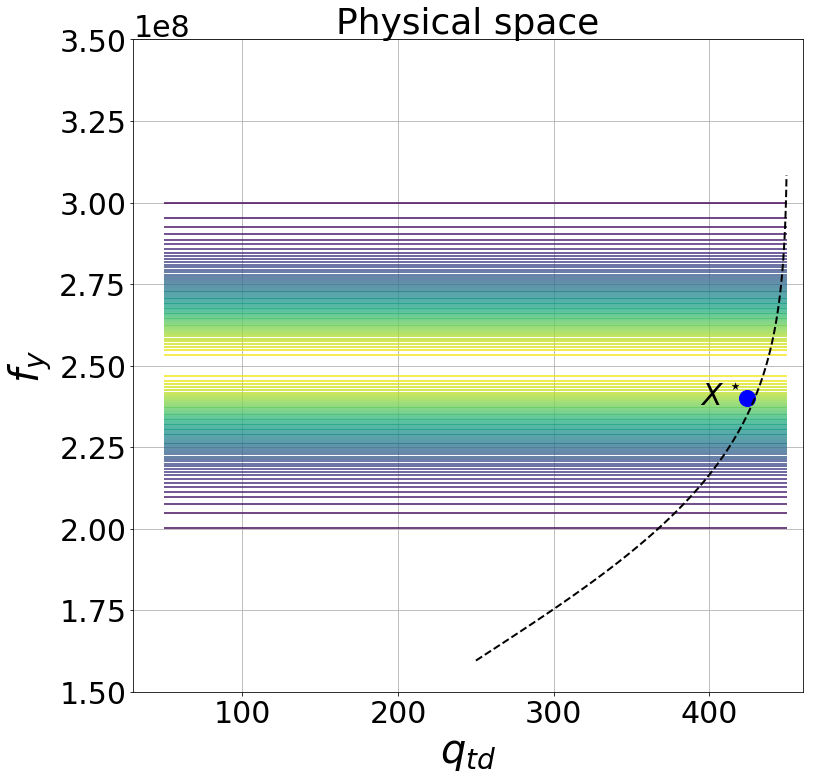

In [13]:
# Figure 13b
MPP_X = [Q.DesignPoint_X[0][0], Q.DesignPoint_X[0][1]]
plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 30})
plt.plot(MPP_X[0]-5, MPP_X[1],'bo',markersize=16)
plt.contour(XX, YY, Z.T, levels=60)
plt.plot(x[:, 0], x[:, 1], 'k--', Linewidth=2,)
plt.xlim([30, 460])
plt.ylim([1.5e8, 3.5e8])
plt.xlabel(r'$q_{td}$', FontSize=40)
plt.ylabel(r'$f_y$', FontSize=40)

plt.text(420, 245025000, '$X^\star$',
         rotation=0,
         horizontalalignment='right',
         verticalalignment='top',
         multialignment='center')


plt.grid()
plt.title('Physical space')    
plt.show()